There are various tools available for using the Carto API from python.

** Carto SQL API: **
* https://carto.com/docs/carto-engine/sql-api/

** Review data types in Carto: **
* https://carto.com/docs/tips-and-tricks/data-types/
* Geometry: Points, Multilinestrings, Multipolygons
* Number: double precision type
* String: text field
* Date/Time: modeled after Postgres datetime, i.e. 2016-01-27T00:00:00Z

Postgres datetime:
* Types: https://www.postgresql.org/docs/9.1/static/datatype-datetime.html
* Functions & Operators: https://www.postgresql.org/docs/9.1/static/functions-datetime.html

Python's datetime, section 8.4: 
* https://docs.python.org/2/library/datetime.html

** Carto Python: **
* https://github.com/CartoDB/carto-python
* Includes support for simplified access to the SQL API and Batch Queries
* Some parts not well documented

** Cartoframes: **
* Github: https://github.com/CartoDB/cartoframes
* Explore the tests to see some advanced usage of carto python library and capabilities of cartoframes: https://github.com/CartoDB/cartoframes/blob/master/test/test_context.py
* Ran into an error using an example from their documentation... bad sign...

** A command line tool that displays OOP design for interacting with Carto tables: **
* https://gist.github.com/andrewxhill/093c89fa45e5f657fec7

**Using the SQL API directly**

Libraries

In [142]:
from configparser import ConfigParser
import requests as req
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

                                            geometry         name
0  POLYGON ((-69.9969376289999 12.57758209800004,...        Aruba
1  POLYGON ((74.89230676300014 37.23111358700004,...  Afghanistan
2  (POLYGON ((11.73751945100014 -16.6925779829998...       Angola
3  (POLYGON ((-63.03766842399995 18.2129580750000...     Anguilla
4  POLYGON ((20.06495568800005 42.54675811800004,...      Albania


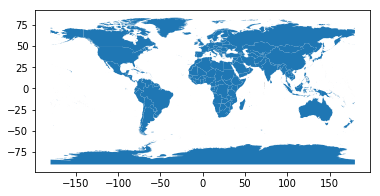

In [168]:
#http://geopandas.org/mergingdata.html
country_bounds = gpd.read_file("/Users/nathansuberi/Downloads/all_countries/all_countries.shp")
country_bounds = country_bounds[["geometry", "name"]]
print(country_bounds.head())
country_bounds.plot()

Helper Functions

In [169]:
def sql_api(url, sql, key):
    # execute sql request over API
    params = {
        'api_key' : key,
        'q'       : sql
    }
    r = req.get(url, params=params)
    return(r)

def create_random_dates(num):
    """
    Will randomly generate "num" number of datetime objects
    year, month, and day are required parameters for datetime
    """
    years = np.random.randint(1990,2017,num)
    months = np.random.randint(1,12,num)
    days = np.random.randint(1,28,num)
    return [datetime(years[i], months[i], days[i]) for i in range(num)]

def dump_row_contents(row, cols_and_types):
    dump = "("
    for ix in row.index:
        if cols_and_types[ix] in ["date", "varchar"]:
            dump += "'" + str(row[ix]) + "',"
        else:
            dump += str(row[ix]) + ","
    dump = dump[:-1]+")"
    return(dump)

def random_points_and_countries(num):
    lats = np.random.rand(num)*180-90
    lons = np.random.rand(num)*360-180
    
    #https://toblerity.org/shapely/manual.html#points
    #Points in lon, lat order: https://macwright.org/2012/10/31/gis-with-python-shapely-fiona.html
    points = [Point(lons[i], lats[i]) for i in range(num)]
    points = gpd.GeoDataFrame({"geometry":points})
    
    # Geom column needs to be named geometry for sjoin to work
    # Note: adding name here, so that can experiment with adding iso3 later
    isos = list(gpd.sjoin(points,country_bounds, how="left", op="intersects")["name"])
    
    return(lats, lons, isos)


Authentication

In [133]:
# Authentication and URL setup

# Base URL for all SQL calls
carto_url = "https://wri-rw.carto.com/api/v2/sql"

# No matter what, we will be using authentication credentials:
config = ConfigParser()
config.read("/Users/nathansuberi/Desktop/Code Portfolio/ResourceWatchCode/.env")
# FROM: https://resourcewatch.carto.com/u/wri-rw/your_apps
carto_api_token = config.get("auth", "carto_api_token")

In [171]:
# Create sample data

# Define the column names and types
cols_and_types = {
    #col name: Carto col type
    "date_of_obs":"date",
    "value":"float",
    "description":"varchar",
    "country":"varchar",
    "lat":"float",
    "lon":"float"
    #"the_geom": "geometry"
}

dates = create_random_dates(10)
lats, lons, countries = random_points_and_countries(10)
data = {
    "date_of_obs":dates,
    "value":np.random.randn(10),
    "description":"test desc",
    "lat":lats,
    "lon":lons,
    "country":countries
    #"the_geom":
}
df = pd.DataFrame(data)
df

,country,date_of_obs,description,lat,lon,value
0,Angola,1994-09-24,test desc,-10.509438,18.477110,-1.341747
1,NaN,2014-07-07,test desc,38.161101,143.069258,0.566282
2,NaN,2008-10-26,test desc,-71.103519,-93.506037,-1.465079
3,Antarctica,1996-10-25,test desc,-87.929475,29.973594,0.671571
4,NaN,1996-02-07,test desc,-3.587292,143.868977,0.310177
5,United States of America,1991-05-18,test desc,42.516540,-112.564750,0.261013
6,Russia,2004-09-26,test desc,52.294520,35.960885,0.930548
7,United States of America,2009-10-04,test desc,37.845906,-104.461827,-0.559607
8,Japan,1993-01-23,test desc,38.415853,140.376270,-0.996406
9,Bolivia,1993-10-21,test desc,-11.717605,-68.865259,-1.277016


In [163]:
# Create table sql
table_name = "Nathan_Carto_SQL_API_test"

columns_and_data_types = ", ".join([col + " " + cols_and_types[col] for col in cols_and_types])

create_table_sql = """
CREATE TABLE {table_name}
 (
 {columns_and_data_types}
 );
""".format(table_name=table_name, columns_and_data_types=columns_and_data_types)

res = sql_api(carto_url, create_table_sql, carto_api_token)
print(res.text)

{"rows":[],"time":0.009,"fields":{},"total_rows":0}


In [164]:
# Select all from a table
table_name = "Nathan_Carto_SQL_API_test"

select_all_sql = """
SELECT * FROM {table_name}
""".format(table_name=table_name)

res = sql_api(carto_url, select_all_sql, carto_api_token)
print(res.text)

{"rows":[],"time":0.001,"fields":{"date_of_obs":{"type":"date"},"value":{"type":"number"},"description":{"type":"string"},"country":{"type":"string"},"lat":{"type":"number"},"lon":{"type":"number"}},"total_rows":0}


In [165]:
# Insert value sql
table_name = "Nathan_Carto_SQL_API_test"

columns = str(tuple(df.columns)).replace("'","")
values = ", ".join(list(df.apply(lambda row: dump_row_contents(row, cols_and_types), axis=1)))

insert_value_sql = """
INSERT INTO {table_name} {columns} VALUES {values}
""".format(table_name=table_name, columns=columns, values=values)

print(insert_value_sql)

res = sql_api(carto_url, insert_value_sql, carto_api_token)
print(res.text)


INSERT INTO Nathan_Carto_SQL_API_test (country, date_of_obs, description, lat, lon, value) VALUES ('MYS','2005-09-08 00:00:00','test desc',2.9560105660963387,112.41890429577114,-0.6710655756000994), ('RUS','2016-03-25 00:00:00','test desc',52.802967899323335,119.15471660965119,-1.072941965446448), ('nan','2013-06-13 00:00:00','test desc',-69.72542084338207,20.507756044489838,-1.1627982768565652), ('nan','2006-06-26 00:00:00','test desc',-52.11089483712965,74.02033268114269,-0.03638669953060347), ('nan','2001-08-18 00:00:00','test desc',-73.61518344213442,-30.708589845521118,-0.8891944100491568), ('nan','1992-07-22 00:00:00','test desc',6.293190061619384,53.15453743909512,-0.7473774876515684), ('nan','2002-11-25 00:00:00','test desc',-9.229579904064181,58.59142654377766,1.6743398140179895), ('nan','1999-06-06 00:00:00','test desc',11.699074645715129,-54.55957754715354,-0.9608173372842964), ('RUS','2000-01-13 00:00:00','test desc',62.42220320228256,102.61675037110746,-0.4887155620642455

In [166]:
# Select all from a table
table_name = "Nathan_Carto_SQL_API_test"

select_all_sql = """
SELECT * FROM {table_name}
""".format(table_name=table_name)

res = sql_api(carto_url, select_all_sql, carto_api_token)
print(res.text)

{"rows":[{"date_of_obs":"2005-09-08T00:00:00Z","value":-0.671065575600099,"description":"test desc","country":"MYS","lat":2.95601056609634,"lon":112.418904295771},{"date_of_obs":"2016-03-25T00:00:00Z","value":-1.07294196544645,"description":"test desc","country":"RUS","lat":52.8029678993233,"lon":119.154716609651},{"date_of_obs":"2013-06-13T00:00:00Z","value":-1.16279827685657,"description":"test desc","country":"nan","lat":-69.7254208433821,"lon":20.5077560444898},{"date_of_obs":"2006-06-26T00:00:00Z","value":-0.0363866995306035,"description":"test desc","country":"nan","lat":-52.1108948371296,"lon":74.0203326811427},{"date_of_obs":"2001-08-18T00:00:00Z","value":-0.889194410049157,"description":"test desc","country":"nan","lat":-73.6151834421344,"lon":-30.7085898455211},{"date_of_obs":"1992-07-22T00:00:00Z","value":-0.747377487651568,"description":"test desc","country":"nan","lat":6.29319006161938,"lon":53.1545374390951},{"date_of_obs":"2002-11-25T00:00:00Z","value":1.67433981401799,"

In [129]:
# Truncate table sql
table_name = "Nathan_Carto_SQL_API_test"

truncate_table_sql = """
TRUNCATE TABLE {table_name}
""".format(table_name=table_name)

res = sql_api(carto_url, truncate_table_sql, carto_api_token)
print(res.text)

{"rows":[],"time":0.012,"fields":{},"total_rows":0}


In [130]:
# Select all from a table
table_name = "Nathan_Carto_SQL_API_test"

select_all_sql = """
SELECT * FROM {table_name}
""".format(table_name=table_name)

res = sql_api(carto_url, select_all_sql, carto_api_token)
print(res.text)

{"rows":[],"time":0.002,"fields":{"date_of_obs":{"type":"date"},"value":{"type":"number"},"description":{"type":"string"},"lat":{"type":"number"},"lon":{"type":"number"}},"total_rows":0}


In [ ]:
# Running Batch Jobs
### This is for running jobs that take a long time in CPU... 
### NOT for running many insert requests as once
### To run many insert requests at once, use the SQL API

In [131]:
# Delete table sql
# Select all from a table
table_name = "Nathan_Carto_SQL_API_test"

delete_table_sql = """
DROP TABLE {table_name}
""".format(table_name=table_name)

res = sql_api(carto_url, delete_table_sql, carto_api_token)
print(res.text)

{"rows":[],"time":0.01,"fields":{},"total_rows":0}


In [132]:
# Select all from a table
table_name = "Nathan_Carto_SQL_API_test"

select_all_sql = """
SELECT * FROM {table_name}
""".format(table_name=table_name)

res = sql_api(carto_url, select_all_sql, carto_api_token)
print(res.text)

{"error":["relation \"nathan_carto_sql_api_test\" does not exist"]}


In [ ]:
# Import table sql
### We will not be using this
### It is for uploading entire files, which we are not doing right now

In [ ]:
# Add a column sql
### Will use for adding ISO

Desired functions for NRT vector processing

In [ ]:
# Reformat data to long form

# Ensure proper time stamp

# Standardize country names, add ISO3

# Add in s2sphere coordinates?

# Upload new rows to Carto table
## Include geometry or not?

# Upload original and edited data to S3



Using the "carto" python package

PACKAGE CONTENTS: auth, datasets, exceptions, export, fields, file_import, maps, paginators, permissions, resources, sql, sync_tables, tables, users, visualizations

In [39]:
import carto
help(carto)

Help on package carto:

NAME
    carto

PACKAGE CONTENTS
    auth
    datasets
    exceptions
    export
    fields
    file_import
    maps
    paginators
    permissions
    resources
    sql
    sync_tables
    tables
    users
    visualizations

FILE
    /Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/carto/__init__.py




In [42]:
# Authenticating
from carto.auth import APIKeyAuthClient

USERNAME="wri-rw"
USR_BASE_URL = "https://{user}.carto.com/".format(user=USERNAME)
auth_client = APIKeyAuthClient(api_key=carto_api_token, base_url=USR_BASE_URL)

In [7]:
# Fetching datasets... 
# Still unclear what this gives besides dataset names
# Warns that this is "non-public" CARTO API and may change in future
from carto.datasets import DatasetManager

dataset_manager = DatasetManager(auth_client)
datasets = dataset_manager.all()

/Users/nathansuberi/.pyenv/versions/3.6.0/lib/python3.6/site-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


In [47]:
help(datasets[0])
print(datasets[0].__dict__)

Help on Dataset in module carto.datasets object:

class Dataset(carto.resources.WarnResource)
 |  Represents a dataset in CARTO. Typically, that means there is a table in
 |  the PostgreSQL server associated to this object.
 |  
 |  .. warning:: Non-public API. It may change with no previous notice
 |  
 |  Method resolution order:
 |      Dataset
 |      carto.resources.WarnResource
 |      pyrestcli.resources.Resource
 |      pyrestcli.resources.APIConnected
 |      builtins.object
 |  
 |  Data descriptors defined here:
 |  
 |  active_layer_id
 |      Convenient class to make explicit that an attribute will store chars
 |  
 |  attributions
 |      Convenient class to make explicit that an attribute will store chars
 |  
 |  auth_tokens
 |      Convenient class to make explicit that an attribute will store chars
 |  
 |  created_at
 |      Field to store datetimes in resources
 |  
 |  description
 |      Convenient class to make explicit that an attribute will store chars
 |  
 | 

In [46]:
# Use table manager... throws an error
from carto.tables import TableManager
help(TableManager)

table_manager = TableManager(auth_client)
#tables = table_manager.all()

Help on class TableManager in module carto.tables:

class TableManager(carto.resources.Manager)
 |  Manager for the Table class.
 |  
 |  .. warning:: Non-public API. It may change with no previous notice
 |  
 |  Method resolution order:
 |      TableManager
 |      carto.resources.Manager
 |      pyrestcli.resources.Manager
 |      pyrestcli.resources.APIConnected
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  paginator_class = <class 'carto.paginators.CartoPaginator'>
 |      Used internally to retrieve results paginated
 |  
 |  resource_class = <class 'carto.tables.Table'>
 |      Represents a table in CARTO. This is an internal data type. Both Table and
 |      TableManager are not meant to be used outside the SDK
 |      
 |      If you are looking to work with datasets / tables from outside the SDK,
 |      please look into the datasets.py file.
 |      
 |      .. warning:: Non-public API. It may change with no previous notice
 |  
 |  ------

In [ ]:
# Running SQL queries
from carto.sql import SQLClient

sql = SQLClient(auth_client)

try:
    data = sql.send('select * from mytable')
except CartoException as e:
    print("some error ocurred", e)

print data['rows']

In [ ]:
# Running batch queries
from carto.sql import BatchSQLClient

LIST_OF_SQL_QUERIES = []

batchSQLClient = BatchSQLClient(auth_client)
createJob = batchSQLClient.create(LIST_OF_SQL_QUERIES)

print(createJob['job_id'])